In [1]:
from HARK.distributions import Bernoulli, Lognormal, MeanOneLogNormal, Normal


from HARK.simulation.monte_carlo import MonteCarloSimulator


import math

In [2]:
from skagent.model import Control, DBlock, RBlock

In [3]:
calibration = {
    "DiscFac": 0.96,
    "CRRA": 2.0,
    "rho" : 0.95,
    "R": 1.03, # will get overridden
    "TranShkStd": 0.1,
    "debt_limit" : -1
}

In [4]:
consumption_block = DBlock(
    **{
        "name": "consumption",
        "shocks": {
            "theta": (Normal, {"mu" : 0, "sigma": "TranShkStd"}),
        },
        "dynamics": {
            "y": lambda y, rho, theta: y * rho + theta,
            "R": Control(["a", "y"]),
            "w": lambda a, R, y: R * a + math.e ** y,
            "c": Control("w"), # constraint c < w - debt_limit
            "a": lambda w, c: w - c,
        },
        "reward": {
            "u": lambda c, CRRA: c ** (1 - CRRA) / (1 - CRRA),
            "d": lambda a, R: - a * R 
        },
    }
)

In [5]:
agent_attribution = {
    "consumer": ["w", "c", "a", "y", "u","rho","theta"],  # consumer
    "lender": ["R", "d"],                   # lender

}

In [6]:
from model_viz import visualize_dblock

Var Type:
  shock_vars: ['theta']
  state_vars: ['y', 'w', 'a']
  control_vars: ['R', 'c']
  reward_vars: ['u', 'd']
  param_vars: ['CRRA', 'DiscFac', 'TranShkStd', 'debt_limit', 'rho']

Depends on:
  theta depends on: ['TranShkStd']
  y depends on: ['theta', 'y', 'rho']
  R depends on: ['y', 'a']
  w depends on: ['R', 'y', 'a']
  c depends on: ['w']
  a depends on: ['c', 'w']
  u depends on: ['c', 'CRRA']
  d depends on: ['R', 'a']

Parameters affect:
  TranShkStd affects: ['theta']
  rho affects: ['y']
  CRRA affects: ['u']

Previous Period Variables:
  ['a', 'y']

Previous Period Dependencies:
  R depends on a*
  w depends on a*
  y depends on y*

Equation:
  CRRA = 2.0
  DiscFac = 0.96
  R = Control(a, y)
  TranShkStd = 0.1
  a = lambda w, c: w - c,
  c = Control(w)
  d = lambda a, R: - a * R
  debt_limit = -1
  rho = 0.95
  u = lambda c, CRRA: c ** (1 - CRRA) / (1 - CRRA),
  w = lambda a*, R, y: R * a* + math.e ** y,
  y = lambda y*, rho, theta: y* * rho + theta,


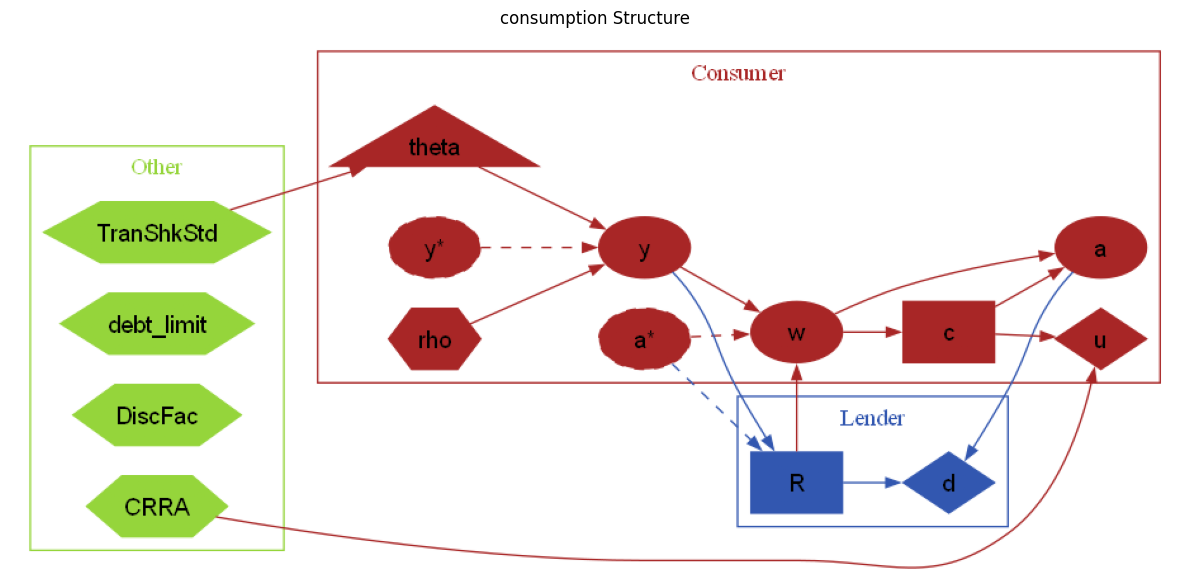

In [7]:
# Create and display graph
graph_1 = visualize_dblock(
    consumption_block, 
    agent_attribution,
    calibration=calibration,
    show=True
)

## How to set $R$

Let `R = Control(a, y)` be the rule for how money is lent.

This is a simple that avoids the state explosion of history.
But since `y` is autoregressive that's fine.

We can look at the dynamics with different rules.

### Todo: test with a couple variations of rules and plot the outcomes.

In [ ]:
sim = MonteCarloSimulator(  ### Use fm, blockified
    calibration,
    consumption_block,
    {
        "R": lambda a, y : 1.03,
        "c": lambda w: w,
    },
    {  # initial states
        "a": 1,
        "y": 1.0,
    },
    agent_count=3,
    T_sim=120,
)

sim.initialize_sim()
hist = sim.simulate()

### Implement value backup on the two rewards, see if it reaches a steady state.

In [ ]:
f = lambda a, b, c, d: a + b - c * d

In [ ]:
args = {
    'a' : 1,
    'b': 2,
    'c' : 3,
    'd' : 4,
    'e' : 5
}

In [ ]:
f(*args)